# Лабораторная работа 5
## Задание 1
## Прогнозирование временных рядов

## Выполнил: __Щеткин Дмитрий Сергеевич__

группа 2.1

### 1. Понимание бизнес-задачи

В этом задании сделана работа с временными рядами и применение различных архитектур рекуррентных нейронных сетей (SimpleRNN, LSTM и Bidirectional LSTM) для прогнозирования будущих значений. Сравнение эффективности этих архитектур и понимание их преимуществ и недостатков в контексте анализа временных рядов.

### 2. Понимание данных

Для этого задания используется датасет “Ежемесячные международные авиаперевозки пассажиров”
(International Airline Passengers). Этот датасет содержит информацию о количестве пассажиров международных
авиалиний за период с 1949 по 1960 год с ежемесячной периодичностью.

### 3. Подготовка данных

In [70]:
# Импорт библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Bidirectional
import math

from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.seasonal import seasonal_decompose

In [5]:
# Загрузка данных
dataset = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv',
usecols=[1], engine='python', skipfooter=3)
data = dataset.values.astype('float32')

In [6]:
# Нормализация данных
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

# Разделение на обучающую и тестовую выборки
train_size = int(len(data) * 0.67)
test_size = len(data) - train_size
train, test = data[0:train_size,:], data[train_size:len(data),:]
print(f"Размер обучающей выборки: {len(train)}, размер тестовой выборки: {len(test)}")

Размер обучающей выборки: 94, размер тестовой выборки: 47


In [28]:
# Функция для создания датасета с временными шагами
def create_dataset(dataset, look_back=1):
  X, Y = [], []
  for i in range(len(dataset) - look_back):
    X.append(dataset[i:(i + look_back), 0])
    Y.append(dataset[i + look_back, 0])
  return np.array(X), np.array(Y)

# Создание датасетов с временными шагами
look_back = 6
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

# Преобразование входных данных для RNN [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

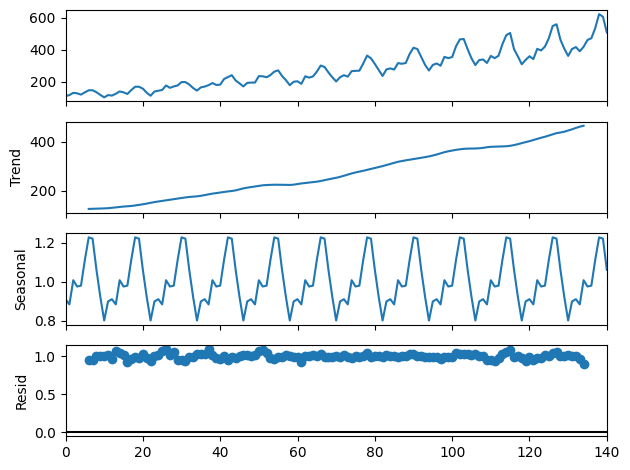

In [71]:
# Влияние сезонности
result = seasonal_decompose(dataset, model='multiplicative', period=12)
result.plot()
plt.show()

### 4. Моделирование

In [50]:
# Создание модели SimpleRNN
def create_simple_rnn_model():
  model = Sequential()
  model.add(SimpleRNN(units=100, activation='tanh', input_shape=(look_back, 1)))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mean_squared_error')
  return model

# Обучение модели SimpleRNN
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
simple_rnn_model = create_simple_rnn_model()
simple_rnn_history = simple_rnn_model.fit(X_train, y_train, epochs=100, batch_size=32,
                                          validation_data=(X_test, y_test),
                                          callbacks=[early_stop], verbose=2)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 - 2s - 653ms/step - loss: 0.0462 - val_loss: 0.0398
Epoch 2/100
3/3 - 0s - 34ms/step - loss: 0.0202 - val_loss: 0.0640
Epoch 3/100
3/3 - 0s - 32ms/step - loss: 0.0154 - val_loss: 0.0363
Epoch 4/100
3/3 - 0s - 48ms/step - loss: 0.0074 - val_loss: 0.0717
Epoch 5/100
3/3 - 0s - 45ms/step - loss: 0.0113 - val_loss: 0.0702
Epoch 6/100
3/3 - 0s - 46ms/step - loss: 0.0094 - val_loss: 0.0419
Epoch 7/100
3/3 - 0s - 47ms/step - loss: 0.0062 - val_loss: 0.0277
Epoch 8/100
3/3 - 0s - 44ms/step - loss: 0.0062 - val_loss: 0.0278
Epoch 9/100
3/3 - 0s - 35ms/step - loss: 0.0068 - val_loss: 0.0257
Epoch 10/100
3/3 - 0s - 32ms/step - loss: 0.0055 - val_loss: 0.0269
Epoch 11/100
3/3 - 0s - 48ms/step - loss: 0.0049 - val_loss: 0.0319
Epoch 12/100
3/3 - 0s - 47ms/step - loss: 0.0053 - val_loss: 0.0326
Epoch 13/100
3/3 - 0s - 46ms/step - loss: 0.0053 - val_loss: 0.0270
Epoch 14/100
3/3 - 0s - 49ms/step - loss: 0.0046 - val_loss: 0.0232
Epoch 15/100
3/3 - 0s - 47ms/step - loss: 0.0045 - val_loss: 0.0215


In [65]:
# Прогнозирование
simple_rnn_train_predict = simple_rnn_model.predict(X_train)
simple_rnn_test_predict = simple_rnn_model.predict(X_test)

# Обратное преобразование прогнозов
simple_rnn_train_predict = scaler.inverse_transform(simple_rnn_train_predict)
simple_rnn_test_predict = scaler.inverse_transform(simple_rnn_test_predict)
y_train_inv = scaler.inverse_transform([y_train])
y_test_inv = scaler.inverse_transform([y_test])

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


In [52]:
# Создание модели LSTM
def create_lstm_model():
  model = Sequential()
  model.add(LSTM(100, activation='tanh', return_sequences=True, input_shape=(look_back, 1)))
  model.add(LSTM(50, activation='tanh'))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mse')
  return model

# Обучение модели LSTM
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lstm_model = create_lstm_model()
lstm_history = lstm_model.fit(X_train, y_train, epochs=100, batch_size=32,
                              validation_data=(X_test, y_test),
                              callbacks=[early_stop], verbose=2)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 - 5s - 2s/step - loss: 0.0520 - val_loss: 0.2264
Epoch 2/100
3/3 - 0s - 52ms/step - loss: 0.0251 - val_loss: 0.1061
Epoch 3/100
3/3 - 0s - 40ms/step - loss: 0.0099 - val_loss: 0.0343
Epoch 4/100
3/3 - 0s - 49ms/step - loss: 0.0120 - val_loss: 0.0269
Epoch 5/100
3/3 - 0s - 47ms/step - loss: 0.0123 - val_loss: 0.0331
Epoch 6/100
3/3 - 0s - 43ms/step - loss: 0.0081 - val_loss: 0.0536
Epoch 7/100
3/3 - 0s - 42ms/step - loss: 0.0078 - val_loss: 0.0691
Epoch 8/100
3/3 - 0s - 47ms/step - loss: 0.0088 - val_loss: 0.0662
Epoch 9/100
3/3 - 0s - 42ms/step - loss: 0.0080 - val_loss: 0.0523
Epoch 10/100
3/3 - 0s - 43ms/step - loss: 0.0067 - val_loss: 0.0359
Epoch 11/100
3/3 - 0s - 47ms/step - loss: 0.0061 - val_loss: 0.0290
Epoch 12/100
3/3 - 0s - 43ms/step - loss: 0.0068 - val_loss: 0.0281
Epoch 13/100
3/3 - 0s - 52ms/step - loss: 0.0064 - val_loss: 0.0302
Epoch 14/100
3/3 - 0s - 51ms/step - loss: 0.0056 - val_loss: 0.0324


In [53]:
# Прогнозирование
lstm_train_predict = lstm_model.predict(X_train)
lstm_test_predict = lstm_model.predict(X_test)

# Обратное преобразование прогнозов
lstm_train_predict = scaler.inverse_transform(lstm_train_predict)
lstm_test_predict = scaler.inverse_transform(lstm_test_predict)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


In [55]:
# Создание модели Bidirectional LSTM
def create_bidirectional_lstm_model():
  model = Sequential()
  model.add(Bidirectional(LSTM(units=50, activation='relu'), input_shape=(look_back, 1)))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mean_squared_error')
  return model

# Обучение модели Bidirectional LSTM
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
bidirectional_lstm_model = create_bidirectional_lstm_model()
bidirectional_lstm_history = bidirectional_lstm_model.fit(X_train, y_train, epochs=100,
                                                          batch_size=32, validation_data=(X_test, y_test),
                                                          callbacks=[early_stop], verbose=2)

Epoch 1/100
3/3 - 5s - 2s/step - loss: 0.0606 - val_loss: 0.3334
Epoch 2/100
3/3 - 0s - 42ms/step - loss: 0.0507 - val_loss: 0.2924
Epoch 3/100
3/3 - 0s - 40ms/step - loss: 0.0413 - val_loss: 0.2536
Epoch 4/100
3/3 - 0s - 39ms/step - loss: 0.0333 - val_loss: 0.2164
Epoch 5/100
3/3 - 0s - 60ms/step - loss: 0.0262 - val_loss: 0.1810
Epoch 6/100
3/3 - 0s - 51ms/step - loss: 0.0201 - val_loss: 0.1484
Epoch 7/100
3/3 - 0s - 50ms/step - loss: 0.0155 - val_loss: 0.1190
Epoch 8/100
3/3 - 0s - 41ms/step - loss: 0.0118 - val_loss: 0.0938
Epoch 9/100
3/3 - 0s - 41ms/step - loss: 0.0097 - val_loss: 0.0728
Epoch 10/100
3/3 - 0s - 42ms/step - loss: 0.0084 - val_loss: 0.0580
Epoch 11/100
3/3 - 0s - 41ms/step - loss: 0.0083 - val_loss: 0.0479
Epoch 12/100
3/3 - 0s - 49ms/step - loss: 0.0083 - val_loss: 0.0426
Epoch 13/100
3/3 - 0s - 98ms/step - loss: 0.0081 - val_loss: 0.0410
Epoch 14/100
3/3 - 0s - 46ms/step - loss: 0.0077 - val_loss: 0.0415
Epoch 15/100
3/3 - 0s - 48ms/step - loss: 0.0071 - val_loss

In [56]:
# Прогнозирование
bidirectional_lstm_train_predict = bidirectional_lstm_model.predict(X_train)
bidirectional_lstm_test_predict = bidirectional_lstm_model.predict(X_test)

# Обратное преобразование прогнозов
bidirectional_lstm_train_predict = scaler.inverse_transform(bidirectional_lstm_train_predict)
bidirectional_lstm_test_predict = scaler.inverse_transform(bidirectional_lstm_test_predict)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


In [27]:
look_backs = [1, 3, 6, 12]
results = []

for lb in look_backs:
    X_train, y_train = create_dataset(train, lb)
    X_test, y_test = create_dataset(test, lb)

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    model = create_lstm_model()
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

    test_pred = model.predict(X_test)
    test_pred = scaler.inverse_transform(test_pred)
    y_test_inv = scaler.inverse_transform([y_test])
    rmse = math.sqrt(mean_squared_error(y_test_inv[0], test_pred[:, 0]))
    results.append((lb, rmse))

for lb, rmse in results:
    print(f"look_back={lb}, Test RMSE={rmse:.2f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
look_back=1, Test RMSE=173.11
look_back=3, Test RMSE=74.31
look_back=6, Test RMSE=80.93
look_back=12, Test RMSE=74.69


Вывод: Слишком маленький look_back не учитывает контекст, а слишком большой усложняет модель и может привести к переобучению.

### 5. Оценка моделей

In [66]:
# Расчет RMSE модели SimpleRNN
simple_rnn_train_rmse = math.sqrt(mean_squared_error(y_train_inv[0], simple_rnn_train_predict[:,0]))
simple_rnn_test_rmse = math.sqrt(mean_squared_error(y_test_inv[0], simple_rnn_test_predict[:,0]))
print(f'SimpleRNN - Ошибка на обучающей выборке (RMSE): {simple_rnn_train_rmse}')
print(f'SimpleRNN - Ошибка на тестовой выборке (RMSE): {simple_rnn_test_rmse}')

# Метрики MAE и MAPE
mae = mean_absolute_error(y_test_inv[0], simple_rnn_test_predict[:, 0])
mape = mean_absolute_percentage_error(y_test_inv[0], simple_rnn_test_predict[:, 0])
print(f"MAE: {mae:.2f}, MAPE: {mape:.2%}")

SimpleRNN - Ошибка на обучающей выборке (RMSE): 23.719575128018775
SimpleRNN - Ошибка на тестовой выборке (RMSE): 49.695882894907946
MAE: 41.65, MAPE: 9.59%


In [67]:
# Расчет RMSE модели LSTM
lstm_train_rmse = math.sqrt(mean_squared_error(y_train_inv[0], lstm_train_predict[:,0]))
lstm_test_rmse = math.sqrt(mean_squared_error(y_test_inv[0], lstm_test_predict[:,0]))
print(f'LSTM - Ошибка на обучающей выборке (RMSE): {lstm_train_rmse}')
print(f'LSTM - Ошибка на тестовой выборке (RMSE): {lstm_test_rmse}')

# Метрики MAE и MAPE
mae = mean_absolute_error(y_test_inv[0], lstm_test_predict[:, 0])
mape = mean_absolute_percentage_error(y_test_inv[0], lstm_test_predict[:, 0])
print(f"MAE: {mae:.2f}, MAPE: {mape:.2%}")

LSTM - Ошибка на обучающей выборке (RMSE): 61.076182741133486
LSTM - Ошибка на тестовой выборке (RMSE): 84.92963316193614
MAE: 71.31, MAPE: 16.80%


In [68]:
# Расчет RMSE модели Bidirectional LSTM
bidirectional_lstm_train_rmse = math.sqrt(mean_squared_error(y_train_inv[0], bidirectional_lstm_train_predict[:,0]))
bidirectional_lstm_test_rmse = math.sqrt(mean_squared_error(y_test_inv[0], bidirectional_lstm_test_predict[:,0]))
print(f'Bidirectional LSTM - Ошибка на обучающей выборке (RMSE):{bidirectional_lstm_train_rmse}')
print(f'Bidirectional LSTM - Ошибка на тестовой выборке (RMSE):{bidirectional_lstm_test_rmse}')

# Метрики MAE и MAPE
mae = mean_absolute_error(y_test_inv[0], bidirectional_lstm_test_predict[:, 0])
mape = mean_absolute_percentage_error(y_test_inv[0], bidirectional_lstm_test_predict[:, 0])
print(f"MAE: {mae:.2f}, MAPE: {mape:.2%}")

Bidirectional LSTM - Ошибка на обучающей выборке (RMSE):35.201825636412195
Bidirectional LSTM - Ошибка на тестовой выборке (RMSE):79.18489831826132
MAE: 66.73, MAPE: 15.71%


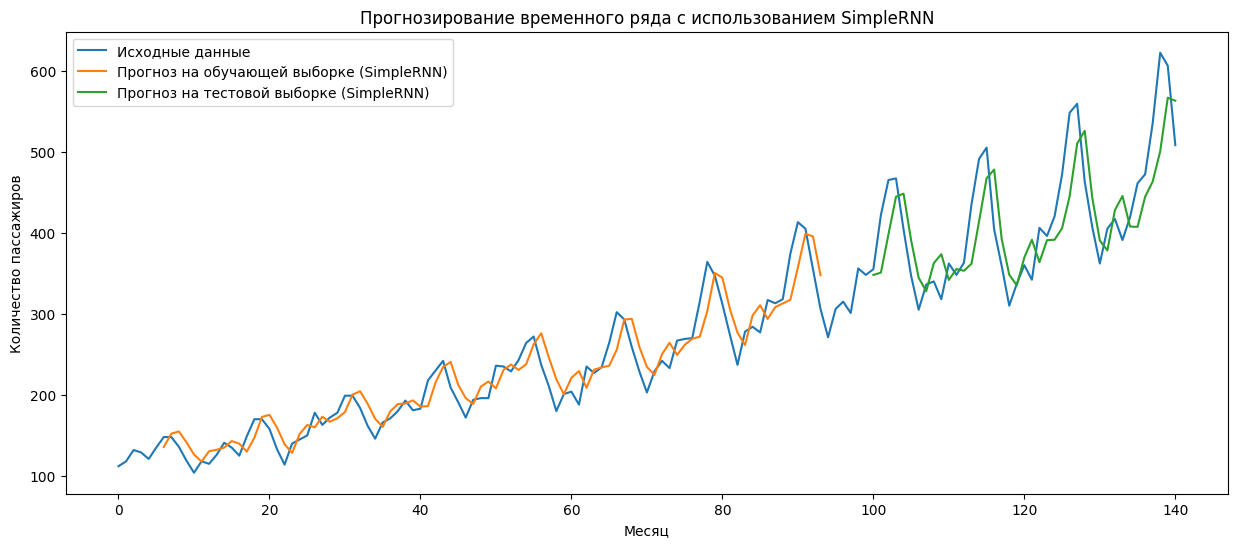

In [60]:
# Подготовка данных для визуализации результатов SimpleRNN
train_plot = np.empty_like(data)
train_plot[:, :] = np.nan
train_plot[look_back:len(simple_rnn_train_predict) + look_back, :] = simple_rnn_train_predict
test_plot = np.empty_like(data)
test_plot[:, :] = np.nan
test_plot[len(simple_rnn_train_predict) + (look_back * 2):len(data), :] = simple_rnn_test_predict

# Визуализация результатов SimpleRNN
plt.figure(figsize=(15, 6))
plt.plot(scaler.inverse_transform(data), label='Исходные данные')
plt.plot(train_plot, label='Прогноз на обучающей выборке (SimpleRNN)')
plt.plot(test_plot, label='Прогноз на тестовой выборке (SimpleRNN)')
plt.title('Прогнозирование временного ряда с использованием SimpleRNN')
plt.xlabel('Месяц')
plt.ylabel('Количество пассажиров')
plt.legend()
plt.show()

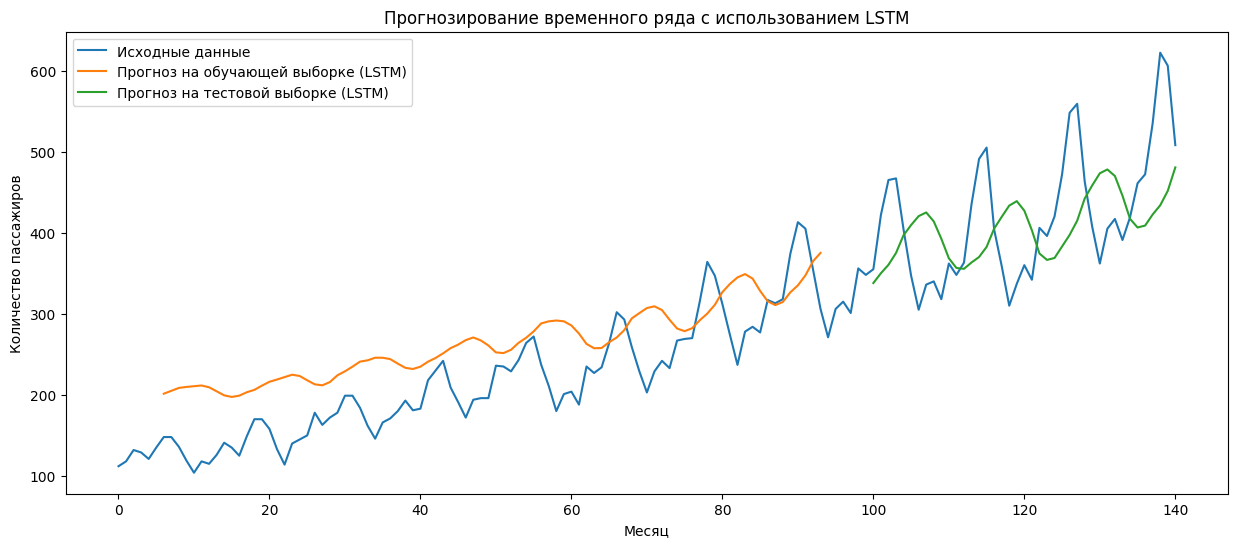

In [59]:
# Подготовка данных для визуализации результатов LSTM
train_plot = np.empty_like(data)
train_plot[:, :] = np.nan
train_plot[look_back:len(lstm_train_predict) + look_back, :] = lstm_train_predict
test_plot = np.empty_like(data)
test_plot[:, :] = np.nan
test_plot[len(lstm_train_predict) + (look_back * 2):len(data), :] = lstm_test_predict

# Визуализация результатов LSTM
plt.figure(figsize=(15, 6))
plt.plot(scaler.inverse_transform(data), label='Исходные данные')
plt.plot(train_plot, label='Прогноз на обучающей выборке (LSTM)')
plt.plot(test_plot, label='Прогноз на тестовой выборке (LSTM)')
plt.title('Прогнозирование временного ряда с использованием LSTM')
plt.xlabel('Месяц')
plt.ylabel('Количество пассажиров')
plt.legend()
plt.show()

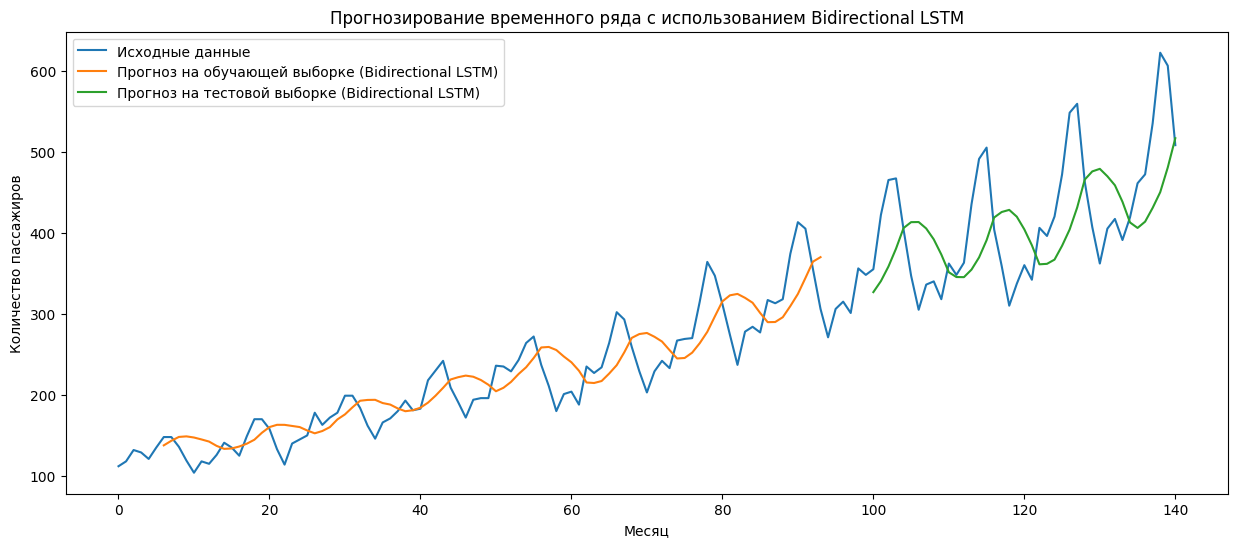

In [58]:
# Подготовка данных для визуализации результатов Bidirectional LSTM
train_plot = np.empty_like(data)
train_plot[:, :] = np.nan
train_plot[look_back:len(bidirectional_lstm_train_predict) + look_back, :] = bidirectional_lstm_train_predict
test_plot = np.empty_like(data)
test_plot[:, :] = np.nan
test_plot[len(bidirectional_lstm_train_predict) + (look_back * 2):len(data), :] = bidirectional_lstm_test_predict

# Визуализация результатов Bidirectional LSTM
plt.figure(figsize=(15, 6))
plt.plot(scaler.inverse_transform(data), label='Исходные данные')
plt.plot(train_plot, label='Прогноз на обучающей выборке (Bidirectional LSTM)')
plt.plot(test_plot, label='Прогноз на тестовой выборке (Bidirectional LSTM)')
plt.title('Прогнозирование временного ряда с использованием Bidirectional LSTM')
plt.xlabel('Месяц')
plt.ylabel('Количество пассажиров')
plt.legend()
plt.show()

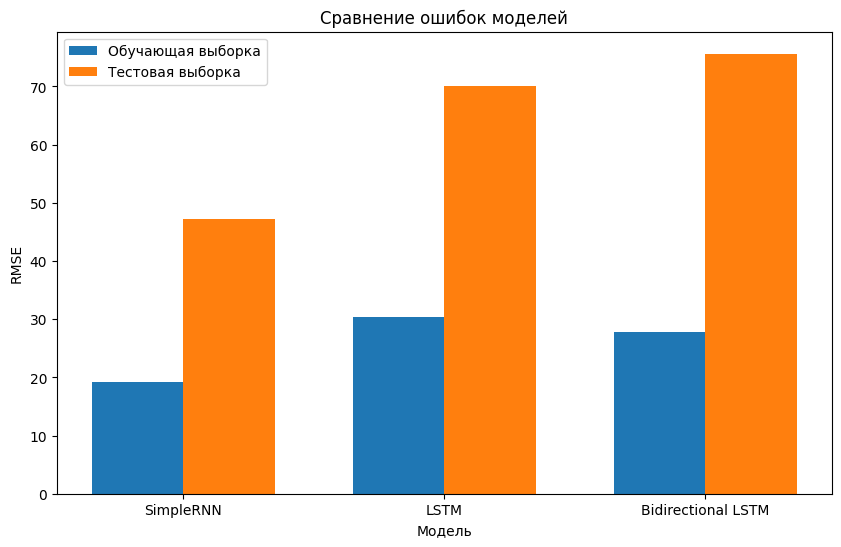

In [57]:
# Сравнение ошибок моделей
models = ['SimpleRNN', 'LSTM', 'Bidirectional LSTM']
train_rmse = [simple_rnn_train_rmse, lstm_train_rmse, bidirectional_lstm_train_rmse]
test_rmse = [simple_rnn_test_rmse, lstm_test_rmse, bidirectional_lstm_test_rmse]
plt.figure(figsize=(10, 6))
x = np.arange(len(models))
width = 0.35
plt.bar(x - width/2, train_rmse, width, label='Обучающая выборка')
plt.bar(x + width/2, test_rmse, width, label='Тестовая выборка')
plt.xlabel('Модель')
plt.ylabel('RMSE')
plt.title('Сравнение ошибок моделей')
plt.xticks(x, models)
plt.legend()
plt.show()

### 6. Развертывание

Практическое применение моделей временных рядов:
- Прогноз спроса, объемов продаж
- Прогноз курсов валют, цен акций, объемов транзакций
- Прогноз трафика, нагрузки на сервер

### 7. Выводы

Сравнение архитектур:
- SimpleRNN: Лучшие показатели на тесте и обучении
- LSTM: RMSE обучающей выборки хуже, чем у других моделей
- Bidirectional LSTM: Хорош на обучении, но плохо обобщает на тест
